1. Data Prepaaration

In [1]:
import pandas as pd
import numpy as np

In [2]:
seq_meta=pd.read_csv(r'D:\kiran\infosys_intern\prognosAI-Infosys-intern-project\milestone_2\week_3\Day_11\sequence_metadata_with_RUL.csv')
df_1=np.load(r'D:\kiran\infosys_intern\prognosAI-Infosys-intern-project\milestone_2\week_3\Day_10\rolling_window_sequences.npy')


In [3]:
print("Sequence Meta Shape:", seq_meta.shape)
print("Rolling Window Sequences Shape:", df_1.shape)
print(type(df_1))


Sequence Meta Shape: (152559, 3)
Rolling Window Sequences Shape: (152559, 30, 66)
<class 'numpy.ndarray'>


In [4]:
# Calculate mean and std per rolling window
sensor_means = df_1.mean(axis=1)
sensor_stds = df_1.std(axis=1)

# Create column names
sensor_cols = [f'sensor_{i+1}' for i in range(sensor_means.shape[1])]

# Convert to DataFrames
mean_df = pd.DataFrame(sensor_means, columns=[f'{col}_mean' for col in sensor_cols])
std_df  = pd.DataFrame(sensor_stds,  columns=[f'{col}_std'  for col in sensor_cols])

# Combine with metadata
data = pd.concat([seq_meta.reset_index(drop=True), mean_df, std_df], axis=1)
data.head()


,engine_id,cycle,RUL,sensor_1_mean,sensor_2_mean,sensor_3_mean,sensor_4_mean,sensor_5_mean,sensor_6_mean,sensor_7_mean,...,sensor_57_std,sensor_58_std,sensor_59_std,sensor_60_std,sensor_61_std,sensor_62_std,sensor_63_std,sensor_64_std,sensor_65_std,sensor_66_std
0,1,8.0,313.0,-0.109839,-0.153646,-0.085651,0.137113,0.097279,0.042308,0.052575,...,0.610620,0.720524,0.876206,0.995261,1.170698,1.039683,0.523865,0.487839,0.522806,0.491397
1,1,8.0,313.0,-0.095721,-0.153646,-0.085651,0.132248,0.092359,0.038232,0.046103,...,0.623896,0.731565,0.888816,1.009925,1.170698,1.039683,0.531030,0.463042,0.529960,0.465024
2,1,9.0,312.0,-0.095719,-0.153673,-0.085651,0.132248,0.092171,0.040418,0.045604,...,0.626618,0.745538,0.892022,1.017915,1.170698,1.039683,0.528055,0.465795,0.527652,0.467535
3,1,9.0,312.0,-0.095730,-0.153609,-0.085651,0.132248,0.091896,0.041772,0.049155,...,0.626626,0.750041,0.892466,1.021599,1.170698,1.039683,0.531641,0.459781,0.531030,0.461694
4,1,9.0,312.0,-0.095739,-0.153582,-0.085651,0.132248,0.091496,0.040641,0.049980,...,0.625774,0.749031,0.891749,1.020538,1.170698,1.039683,0.530613,0.466816,0.530172,0.469704


In [8]:
# Normalize RUL per unit (optional)
merged_df['normalized_RUL'] = merged_df.groupby('cycle')['RUL'].transform(lambda x: x / x.max())

# Define operational phase
merged_df['phase'] = pd.cut(merged_df['normalized_RUL'], bins=[0, 0.3, 1], labels=['late', 'early'])


In [6]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

Two-sample t-test for Sensor 7 Mean (early vs late)

Test 1: Two-sample t-test on Sensor 7 Mean (early vs late)
T-statistic: -22.1072, P-value: 0.0000
→ Reject H₀: Sensor 7 mean differs significantly between early and late phases.


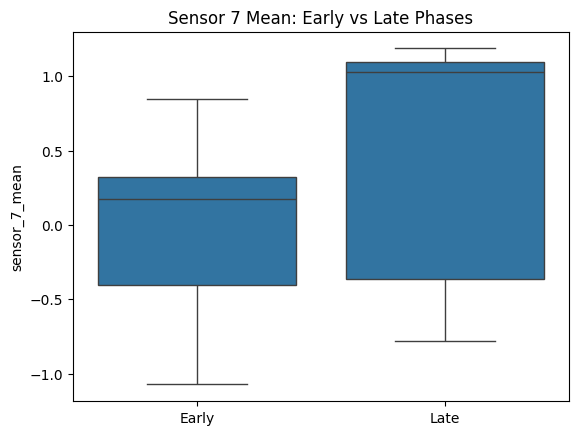

In [7]:
early = data[data['cycle'] <= data['cycle'].max() * 0.3]['sensor_7_mean']
late  = data[data['cycle'] >= data['cycle'].max() * 0.7]['sensor_7_mean']

t_stat, p_val = stats.ttest_ind(early, late, equal_var=False)

print("Test 1: Two-sample t-test on Sensor 7 Mean (early vs late)")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("→ Reject H₀: Sensor 7 mean differs significantly between early and late phases.")
else:
    print("→ Fail to reject H₀: No significant change in sensor 7 mean.")

sns.boxplot(x=['Early']*len(early) + ['Late']*len(late),
            y=pd.concat([early, late]))
plt.title("Sensor 7 Mean: Early vs Late Phases")
plt.show()


Mann-Whitney U Test for Sensor 7 Std (early vs late)

Test 2: Mann-Whitney U Test on Sensor 7 Std (early vs late)
U-statistic: 116094889.0000, P-value: 0.0000
→ Reject H₀: Sensor 7 Std shows significant change across operational phases.


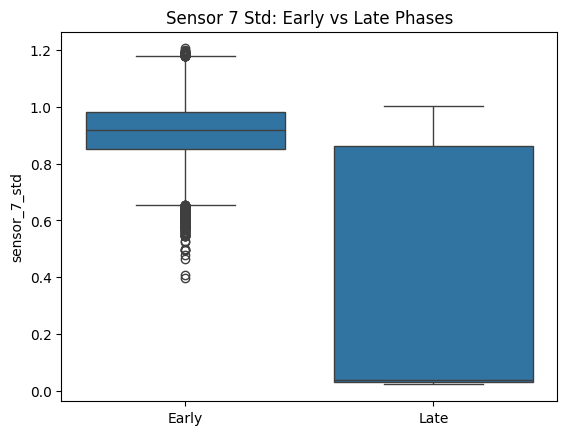

In [8]:
early_std = data[data['cycle'] <= data['cycle'].max() * 0.3]['sensor_7_std']
late_std  = data[data['cycle'] >= data['cycle'].max() * 0.7]['sensor_7_std']

u_stat, p_val = stats.mannwhitneyu(early_std, late_std)

print("Test 2: Mann-Whitney U Test on Sensor 7 Std (early vs late)")
print(f"U-statistic: {u_stat:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("→ Reject H₀: Sensor 7 Std shows significant change across operational phases.")
else:
    print("→ Fail to reject H₀.")

sns.boxplot(x=['Early']*len(early_std) + ['Late']*len(late_std),
            y=pd.concat([early_std, late_std]))
plt.title("Sensor 7 Std: Early vs Late Phases")
plt.show()


Pearson Correlation (Sensor 11 Mean vs RUL)

Test 3: Pearson Correlation between Sensor 11 Mean and RUL
r = 0.1673, P-value: 0.0000
→ Reject H₀: Significant linear correlation between sensor 11 mean and RUL.


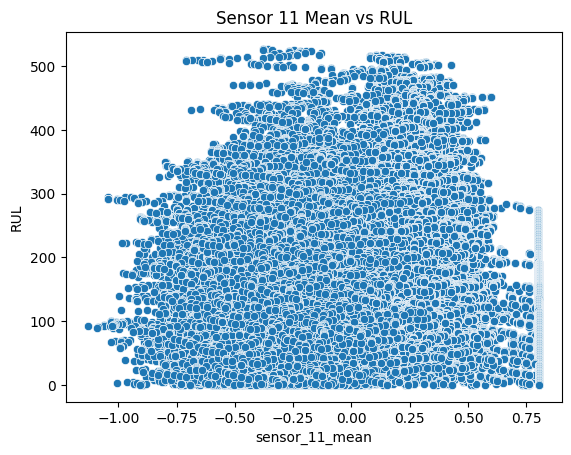

In [9]:
r, p_val = stats.pearsonr(data['sensor_11_mean'], data['RUL'])

print("Test 3: Pearson Correlation between Sensor 11 Mean and RUL")
print(f"r = {r:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("→ Reject H₀: Significant linear correlation between sensor 11 mean and RUL.")
else:
    print("→ Fail to reject H₀.")

sns.scatterplot(x='sensor_11_mean', y='RUL', data=data)
plt.title("Sensor 11 Mean vs RUL")
plt.show()


Spearman Correlation (Sensor 15 Std vs RUL)

Test 4: Spearman Correlation between Sensor 15 Std and RUL
ρ = 0.2373, P-value: 0.0000
→ Reject H₀: Sensor 15 Std significantly correlates with RUL.


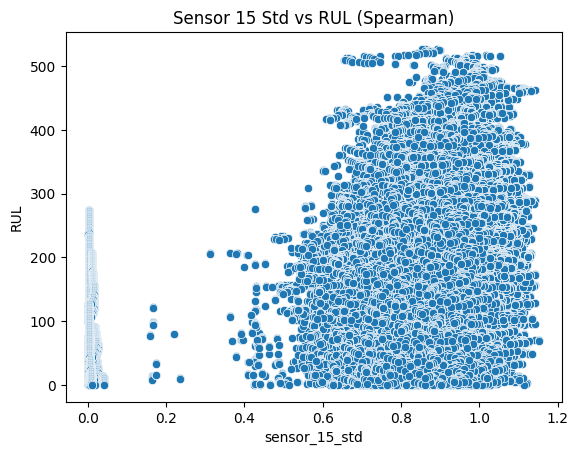

In [10]:
rho, p_val = stats.spearmanr(data['sensor_15_std'], data['RUL'])

print("Test 4: Spearman Correlation between Sensor 15 Std and RUL")
print(f"ρ = {rho:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("→ Reject H₀: Sensor 15 Std significantly correlates with RUL.")
else:
    print("→ Fail to reject H₀.")

sns.scatterplot(x='sensor_15_std', y='RUL', data=data)
plt.title("Sensor 15 Std vs RUL (Spearman)")
plt.show()


ANOVA (F-test) for Sensor 10 Mean across RUL Bins

Test 5: ANOVA on Sensor 10 Mean across RUL stages
F-statistic: 1941.7139, P-value: 0.0000
→ Reject H₀: Sensor 10 Mean differs significantly across RUL stages.


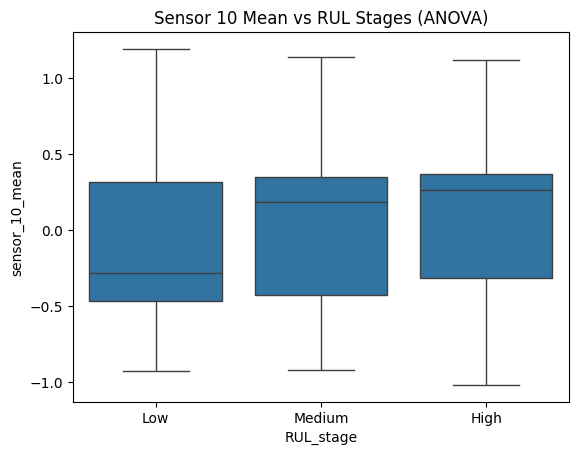

In [11]:
data['RUL_stage'] = pd.qcut(data['RUL'], q=3, labels=['Low', 'Medium', 'High'])

groups = [data[data['RUL_stage']==stage]['sensor_10_mean'] for stage in ['Low', 'Medium', 'High']]

f_stat, p_val = stats.f_oneway(*groups)

print("Test 5: ANOVA on Sensor 10 Mean across RUL stages")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_val:.4f}")
if p_val < 0.05:
    print("→ Reject H₀: Sensor 10 Mean differs significantly across RUL stages.")
else:
    print("→ Fail to reject H₀.")

sns.boxplot(x='RUL_stage', y='sensor_10_mean', data=data)
plt.title("Sensor 10 Mean vs RUL Stages (ANOVA)")
plt.show()
